# Sää ja sähkö


In [1]:
import datetime as dt
import xmltodict
import pandas as pd
from catboost import Pool, CatBoostRegressor
from fmiopendata.wfs import download_stored_query
import seaborn as sns


def date_range(start_date, end_date, max_days):
    current_date = start_date
    while (end_date - current_date).days > max_days:
        chunk_end = current_date + dt.timedelta(days=max_days - 1)
        yield (current_date, chunk_end)
        current_date = chunk_end + dt.timedelta(days=1)
    yield (current_date, end_date)

# Weather data

Weather data is collected from [Finnish Meteorological Institute open data](https://en.ilmatieteenlaitos.fi/open-data) with [`fmiopendata`](https://github.com/pnuu/fmiopendata) Python library.


In [44]:
def get_weather_df(start_date: dt.date, end_date: dt.date) -> pd.DataFrame:
    """Fetch weather data between given dates

    Args:
        start_date (dt.date): Start date of requested weather data
        end_date (dt.date): End date of requested weather data
    """
    weather_data = {}
    for start, end in date_range(start_date, end_date, 31):
        start_string = start.strftime("%Y-%m-%d") + "T00:00:00Z"
        end_string = end.strftime("%Y-%m-%d") + "T23:59:59Z"
        data_chunk = download_stored_query(
            "fmi::observations::weather::hourly::multipointcoverage",
            [
                "place=kaisaniemi,helsinki",
                "starttime=" + start_string,
                "endtime=" + end_string,
            ],
        ).data
        weather_data.update(data_chunk)

    dates = []
    air_temperatures = []
    wind_speeds = []
    precipitation_amounts = []

    for datetime, data in weather_data.items():
        dates.append(datetime)
        air_temperatures.append(data["Helsinki Kaisaniemi"]["Air temperature"]["value"])
        wind_speeds.append(data["Helsinki Kaisaniemi"]["Wind speed"]["value"])
        precipitation_amounts.append(
            data["Helsinki Kaisaniemi"]["Precipitation amount"]["value"]
        )

    weather_df = pd.DataFrame(
        {
            "datetime": dates,
            "air temperatures": air_temperatures,
            "wind speeds": wind_speeds,
            "precipitation amounts": precipitation_amounts,
        }
    )

    return (weather_data, weather_df)

# Energy data

Energy data is obtained from [ENTSO-E (European Network of Transmission System Operators for Electricity) API](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show).


Not enough energy data for 2024-03-04 01:00:00
             datetime  consumption
0 2024-01-01 01:00:00     12429.75
1 2024-01-01 02:00:00     12297.75
2 2024-01-01 03:00:00     12168.50
3 2024-01-01 04:00:00     12185.00
4 2024-01-01 05:00:00     12229.75


<Axes: >

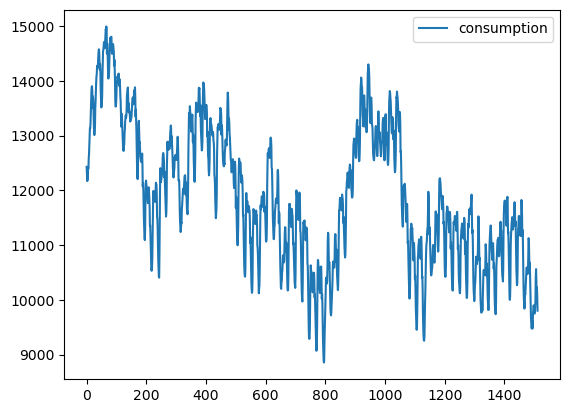

In [32]:
energy_data_file_names = ["data/ACTUAL_TOTAL_LOAD_202401010000-202501010000.xml"]
data = []
for filename in energy_data_file_names:
    with open(filename, "r") as file:
        data_string = file.read()
        yearly_data = xmltodict.parse(data_string)["GL_MarketDocument"]["TimeSeries"]
        data += yearly_data

energy_data = [day["Period"] for day in data]
hourly_means = {}

times = []
values = []

for day in energy_data:
    time = dt.datetime.strptime(
        day["timeInterval"]["start"], "%Y-%m-%dT%H:%MZ"
    ) + dt.timedelta(hours=2)
    fifteen_min_means = [int(fifteen_min["quantity"]) for fifteen_min in day["Point"]]
    if len(fifteen_min_means) != 96:
        print("Not enough energy data for", time)
        break
    i = 0
    while i < len(fifteen_min_means):
        hourly_means[time] = sum(fifteen_min_means[i : i + 4]) / 4
        times.append(time)
        values.append(sum(fifteen_min_means[i : i + 4]) / 4)
        time += dt.timedelta(hours=1)
        i += 4

energy_df = pd.DataFrame({"datetime": times, "consumption": values})
print(energy_df.head())
sns.lineplot(energy_df)

# Predictions

Predictions are made with [CatBoost library](https://catboost.ai/).


In [56]:
start_date = dt.date(2024, 1, 1)
end_date = dt.date(2024, 3, 3)
weather_data = get_weather_df(start_date, end_date)[0]

data_matrix = []
labels = []
day_of_week = 0
for time, weather in weather_data.items():
    if time not in hourly_means:
        print("No energy data for", time)
        continue
    data_matrix.append(
        [
            weather["Helsinki Kaisaniemi"]["Air temperature"]["value"],
            weather["Helsinki Kaisaniemi"]["Wind speed"]["value"],
            weather["Helsinki Kaisaniemi"]["Precipitation amount"]["value"],
            str(day_of_week),
        ]
    )
    if time.hour == 23:
        day_of_week = (day_of_week + 1) % 7
    labels.append(hourly_means[time])

# print("data_matrix")
# print(data_matrix[:10])

train_data = data_matrix[: int(0.8 * len(data_matrix))]
test_data = data_matrix[int(0.8 * len(data_matrix)) :]

train_pool = Pool(train_data, labels[: int(0.8 * len(labels))], cat_features=[3])
test_pool = Pool(test_data, cat_features=[3])
model = CatBoostRegressor(iterations=2, depth=2, learning_rate=1, loss_function="RMSE")
model.fit(train_pool)
predictions = model.predict(test_pool)
# print(f"{train_data = }")
# print(f"{test_data = }")

print(predictions)

No observations found
No energy data for 2024-01-01 00:00:00
0:	learn: 702.7203757	total: 1.23ms	remaining: 1.23ms
1:	learn: 628.4666703	total: 2.31ms	remaining: 0us
train_data = [[-14.7, 2.9, 0.0, '0'], [-14.6, 2.5, 0.0, '0'], [-14.3, 2.8, 0.0, '0'], [-14.2, 3.2, 0.0, '0'], [-14.5, 3.8, 0.0, '0'], [-15.2, 3.6, 0.0, '0'], [-15.6, 3.7, 0.0, '0'], [-15.9, 4.0, 0.0, '0'], [-16.0, 4.7, 0.0, '0'], [-15.9, 4.4, 0.0, '0'], [-15.7, 4.2, 0.0, '0'], [-15.7, 4.4, 0.0, '0'], [-15.9, 4.3, 0.0, '0'], [-16.3, 5.2, 0.0, '0'], [-16.9, 5.8, 0.0, '0'], [-17.0, 5.3, 0.0, '0'], [-17.3, 5.1, 0.0, '0'], [-17.0, 5.9, 0.0, '0'], [-17.0, 5.3, 0.0, '0'], [-16.8, 4.6, 0.0, '0'], [-16.5, 4.3, 0.0, '0'], [-16.5, 4.6, 0.0, '0'], [-16.6, 4.8, 0.0, '0'], [-16.7, 4.9, 0.0, '1'], [-16.4, 5.4, 0.0, '1'], [-15.9, 4.9, 0.0, '1'], [-15.3, 4.9, 0.0, '1'], [-15.1, 4.6, 0.0, '1'], [-15.0, 5.0, 0.0, '1'], [-14.4, nan, 0.0, '1'], [-14.8, 5.6, 0.0, '1'], [-15.2, 4.7, 0.0, '1'], [-15.0, 4.5, 0.0, '1'], [-15.5, 3.8, 0.0, '1'], [-15

/home/tuukkala/anaconda3/envs/sus/lib/python3.11/site-packages/fmiopendata/utils.py:43: UserWarning: 

FMI servers responded with the following errors:

 - Too long time interval requested!
 - No more than 744.000000 hours allowed.
 - URI: /wfs?endtime=2024-03-03T23%3A59%3A59Z&place=kaisaniemi%2Chelsinki&request=getFeature&service=WFS&starttime=2024-02-01T00%3A00%3A00Z&storedquery_id=fmi%3A%3Aobservations%3A%3Aweather%3A%3Ahourly%3A%3Amultipointcoverage&version=2.0.0

  warnings.warn(exception_text)


In [66]:
# forecast accuracy with MAPE

actual = labels[int(0.8 * len(labels)) :]
mape = 0
for i in range(len(predictions)):
    mape += abs((actual[i] - predictions[i]) / actual[i]) / len(predictions)

print(f"{mape = }")

mape = 0.04859686603768826


In [38]:
# joining the weather and consumption data

train_weather = get_weather_df(dt.date(2023, 1, 1), dt.date(2023, 12, 31))


train_data = train_weather.set_index("datetime").join(energy_df.set_index("datetime"))

,air temperatures,wind speeds,precipitation amounts,consumption
datetime,,,,
2024-01-01 00:00:00,-14.4,2.6,0.0,NaN
2024-01-01 01:00:00,-14.7,2.9,0.0,12429.75
2024-01-01 02:00:00,-14.6,2.5,0.0,12297.75
2024-01-01 03:00:00,-14.3,2.8,0.0,12168.50
2024-01-01 04:00:00,-14.2,3.2,0.0,12185.00
